<h1>1. Importing the required Libraries</h1>

In [1]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#Loading and processing image
import cv2 
import imghdr 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

#Loading saved models
from tensorflow.keras.models import load_model

<h1>2. Limiting VRAM usage</h1>

In [2]:
#Display GPUs available.
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

<h3>1.3 Cleaning Images (Removing dodgy ones)</h3>

In [4]:
data_directory = 'plant_disease_dataset/train'
validation_directory = 'plant_disease_dataset/valid'
test_directory = 'plant_disease_dataset/test'
image_extensions = ['jpeg', 'png', 'jpg', 'bmp']

<h1>3. Cleaning Image Data</h1>

In [5]:
#Removing images that would cause processing issues.
for image_class in tqdm(os.listdir(data_directory)): 
    for image in os.listdir(os.path.join(data_directory, image_class)): 
        image_path = os.path.join(data_directory, image_class, image) 
        
        try:
            img = cv2.imread(image_path) 
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print(f'Image {image_path} not in extensions list')
                os.remove(image_path) 

        except Exception as e:
            print(f'Issue with image {image_path}')

for image_class in tqdm(os.listdir(validation_directory)): 
    for image in os.listdir(os.path.join(data_directory, image_class)): 
        image_path = os.path.join(data_directory, image_class, image) 
        
        try:
            img = cv2.imread(image_path) 
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print(f'Image {image_path} not in extensions list')
                os.remove(image_path) 

        except Exception as e:
            print(f'Issue with image {image_path}')

for image_class in tqdm(os.listdir(test_directory)): 
    for image in os.listdir(os.path.join(data_directory, image_class)): 
        image_path = os.path.join(data_directory, image_class, image) 
        
        try:
            img = cv2.imread(image_path) 
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print(f'Image {image_path} not in extensions list')
                os.remove(image_path) 

        except Exception as e:
            print(f'Issue with image {image_path}')

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:42<00:00,  1.12s/it]


<h1>4 Loading the Data</h1>

In [6]:
#Generating batches of images with data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    shear_range=0.1,  
    zoom_range=0.1,  
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
#Generating resized batches of data
train_dataset = train_datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_dataset = val_datagen.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_dataset = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

Found 70181 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 114 images belonging to 38 classes.


<h1>5. Modelling</h1>

In [8]:
model = Sequential()

In [9]:
model = tf.keras.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3),
                        kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Third convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

# Flatten and Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dense(38, activation='softmax'))

In [10]:
#Compiling the model
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)      

<h1>6. Training</h1>

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [13]:
hist = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
2194/2194 [==============================] - 640s 289ms/step - loss: 2.4739 - accuracy: 0.3802 - val_loss: 1.5154 - val_accuracy: 0.6563
Epoch 2/20
2194/2194 [==============================] - 671s 306ms/step - loss: 1.1721 - accuracy: 0.7462 - val_loss: 1.1726 - val_accuracy: 0.7692
Epoch 3/20
2194/2194 [==============================] - 694s 316ms/step - loss: 1.0157 - accuracy: 0.7997 - val_loss: 0.8991 - val_accuracy: 0.8399
Epoch 4/20
2194/2194 [==============================] - 678s 309ms/step - loss: 0.9332 - accuracy: 0.8255 - val_loss: 0.9695 - val_accuracy: 0.8169
Epoch 5/20
2194/2194 [==============================] - 679s 309ms/step - loss: 0.8793 - accuracy: 0.8426 - val_loss: 0.9148 - val_accuracy: 0.8341
Epoch 6/20
2194/2194 [==============================] - 662s 302ms/step - loss: 0.6685 - accuracy: 0.9024 - val_loss: 0.7012 - val_accuracy: 0.8705
Epoch 7/20
2194/2194 [==============================] - 656s 299ms/step - loss: 0.5459 - accuracy: 0.9167 - val_

<h1>7. Plotting the Performance</h1>

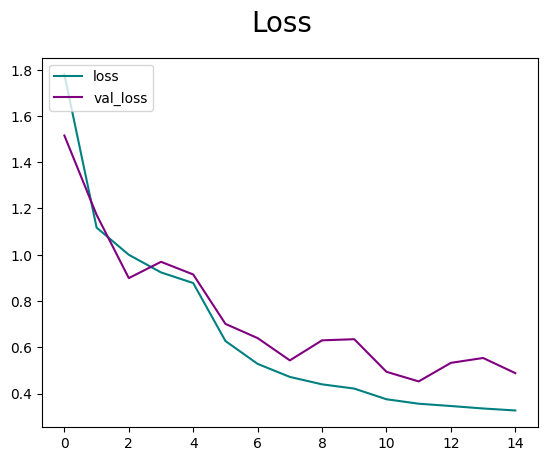

In [14]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='purple', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

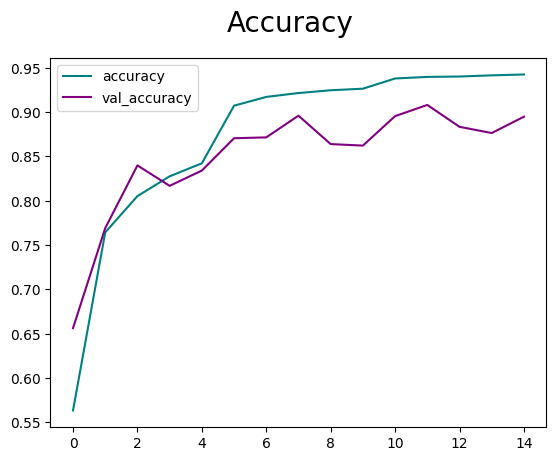

In [15]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='purple', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

<h1>8. Evaluating the Model</h1>

In [29]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

4/4 [==============================] - 1s 101ms/step - loss: 0.5224 - accuracy: 0.9123
Test Loss: 0.5223610997200012, Test Accuracy: 0.9122806787490845


In [30]:
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_dataset.classes
precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9171052631578948
Recall: 0.9122807017543859
F1 Score: 0.9013157894736842


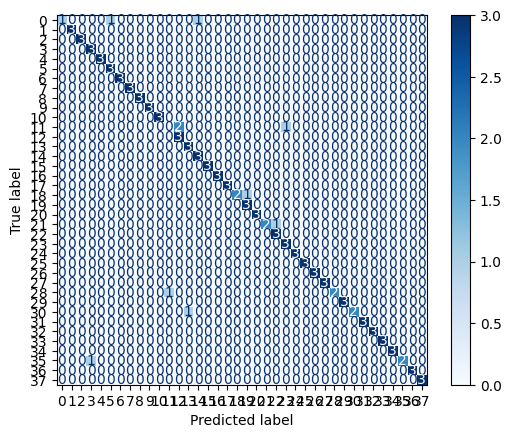

In [31]:
cm = confusion_matrix(true_classes, predicted_classes)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

<h1>8. Predicting single image</h1>

In [19]:
classes = os.listdir(os.path.join('plant_disease_dataset', 'train'))

In [24]:
# Load and preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):  # Adjust to target_size used in training
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Predict the class of a single image
def predict_image_class(img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path, target_size=(224, 224))  # Match target size to training
    
    # Get predictions
    predictions = model.predict(img_array)
    
    # Get the index of the highest probability
    predicted_index = np.argmax(predictions, axis=1)[0]
    
    # Get the class name
    predicted_class = classes[predicted_index]
    
    return predicted_class

# Example usage
img_path = 'plant_disease_dataset/test/Apple___Black_rot/00e909aa-e3ae-4558-9961-336bb0f35db3___JR_FrgE.S 8593.JPG'  
predicted_class = predict_image_class(img_path)
print(f"The predicted class is: {predicted_class}")

The predicted class is: Apple___Black_rot


<h1>5. Saving the Model</h1>

In [25]:
model.save(os.path.join('good_models', 'good_leaf_disease_model_3.0_.h5')) #h5 is equivalent to zipping

In [27]:
#new_model = load_model(os.path.join('good_models', 'good_leaf_disease_model_3.0_.h5'))